In [4]:
import re
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from pathlib import Path
import numpy as np


## Data Preprocessing


In [5]:
def clean_text(text):
    """Clean tweet text by removing URLs, mentions, and extra whitespace"""
    text = str(text)
    text = re.sub(r"http\S+", "", text)      # Remove URLs
    text = re.sub(r"@\w+", "", text)         # Remove mentions
    text = re.sub(r"^user:\s*", "", text, flags=re.IGNORECASE)  
    text = re.sub(r"^user\s*", "", text, flags=re.IGNORECASE)  
    text = re.sub(r"[\"]+", "", text)        # Remove quotes
    text = re.sub(r"\s+", " ", text).strip() # Normalize whitespace
    return text

def labels_zero_one(y: int) -> int:
    """Convert {-1, 1} labels to {0, 1} for binary classification"""
    return 1 if int(y) == 1 else 0


In [6]:
# Load and preprocess data
df = pd.read_csv("data/stock_data.csv")
df["Text"] = df["Text"].astype(str).apply(clean_text)

print(f"Dataset size: {len(df)} samples")
print(f"\nClass distribution:")
print(df["Sentiment"].value_counts())
print(f"\nSample texts:")
print(df.head())


Dataset size: 5791 samples

Class distribution:
Sentiment
 1    3685
-1    2106
Name: count, dtype: int64

Sample texts:
                                                Text  Sentiment
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1
1  AAP MOVIE. 55% return for the FEA/GEED indicat...          1
2  I'd be afraid to short AMZN - they are looking...          1
3                                    MNTA Over 12.00          1
4                                      OI Over 21.37          1


## Dataset Class


In [7]:
class FinancialSentimentDataset(Dataset):
    """Dataset for financial sentiment classification"""
    
    def __init__(self, texts, labels, tokenizer, max_len: int = 128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            "label": torch.tensor(label, dtype=torch.long)
        }


## Model Architecture


In [8]:
class TransformerBackbone(nn.Module):
    """Generic transformer encoder backbone"""
    
    def __init__(self, modelName: str = "albert-base-v2"):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(modelName)
        self.hiddenSize = self.encoder.config.hidden_size

    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        cls = out.last_hidden_state[:, 0]  # [CLS] token representation
        return cls


class BinaryHead(nn.Module):
    """Binary classification head with dropout regularization"""
    
    def __init__(self, inFeatures: int, pDrop: float = 0.3):
        super().__init__()
        self.dropout = nn.Dropout(pDrop)
        self.fc = nn.Linear(inFeatures, 1)

    def forward(self, x):
        x = self.dropout(x)
        logits = self.fc(x).squeeze(-1)
        return logits


class SentimentClassifier(nn.Module):
    """Complete sentiment classification model"""
    
    def __init__(self, modelName: str = "albert-base-v2", pDrop: float = 0.3):
        super().__init__()
        self.backbone = TransformerBackbone(modelName)
        self.head = BinaryHead(self.backbone.hiddenSize, pDrop)

    def forward(self, input_ids, attention_mask):
        feats = self.backbone(input_ids, attention_mask)
        logits = self.head(feats)
        return logits


## Training Functions


In [9]:
def step(model, batch, device, optimizer=None, train=True, clip=1.0):
    """Single training/validation step"""
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["label"].float().to(device)

    logits = model(input_ids, attention_mask)
    loss = F.binary_cross_entropy_with_logits(logits, labels)

    if train:
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    probs = torch.sigmoid(logits).detach().cpu().numpy()
    preds = (probs >= 0.5).astype(int)
    y_true = labels.detach().cpu().numpy().astype(int)
    return loss.item(), preds, y_true


def runEpoch(model, loader, device, optimizer=None, scheduler=None, train=True):
    """Run one epoch of training or validation"""
    model.train(train)
    losses, allPreds, allTrue = [], [], []
    
    for batch in loader:
        loss, preds, y_true = step(model, batch, device, optimizer, train)
        losses.append(loss)
        allPreds.extend(preds.tolist())
        allTrue.extend(y_true.tolist())
        
        if train and scheduler is not None:
            scheduler.step()
    
    avg_loss = float(sum(losses) / max(1, len(losses)))
    acc = accuracy_score(allTrue, allPreds)
    f1 = f1_score(allTrue, allPreds)
    
    return avg_loss, acc, f1


## Data Preparation


In [10]:
# Model configuration
MODEL_NAME = "albert-base-v2"  # 12M parameters - perfect for ~4K samples
MAX_LEN = 128
BATCH_SIZE = 32  # Smaller batch for better generalization
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
DROPOUT = 0.3  # Higher dropout for regularization
MAX_EPOCHS = 20
PATIENCE = 3  # Early stopping patience
WARMUP_STEPS = 100

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Prepare data splits
labels_binary = df["Sentiment"].apply(labels_zero_one).values
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Text"].values, 
    labels_binary, 
    test_size=0.2, 
    random_state=67,
    stratify=labels_binary  # Stratified split for balanced classes
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"\nTraining class distribution: {np.bincount(train_labels)}")
print(f"Validation class distribution: {np.bincount(val_labels)}")

# Create datasets and loaders
train_dataset = FinancialSentimentDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = FinancialSentimentDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nBatches per epoch: {len(train_loader)}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

d:\CODE\Deep_ml_project\AI-financial-sentiment-prediction\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\hf_cache\models--albert-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Training samples: 4632
Validation samples: 1159

Training class distribution: [1685 2947]
Validation class distribution: [421 738]

Batches per epoch: 145


## Model Initialization


In [11]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = SentimentClassifier(MODEL_NAME, pDrop=DROPOUT).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Data-to-parameter ratio: {len(train_texts) / trainable_params:.6f}")


Using device: cuda


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 3ae53282-a61e-496d-8db9-eeb5bcee4e87)')' thrown while requesting HEAD https://huggingface.co/albert-base-v2/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]


Total parameters: 11,684,353
Trainable parameters: 11,684,353
Data-to-parameter ratio: 0.000396


## Training with Optimizations


In [12]:
# Setup optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * MAX_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {WARMUP_STEPS}")
print(f"\nStarting training...\n")

# Training loop with early stopping
best_val_loss = float('inf')
best_val_f1 = 0.0
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'train_f1': [],
           'val_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(MAX_EPOCHS):
    # Training
    train_loss, train_acc, train_f1 = runEpoch(
        model, train_loader, device, optimizer, scheduler, train=True
    )
    
    # Validation
    val_loss, val_acc, val_f1 = runEpoch(
        model, val_loader, device, train=False
    )
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # Print progress
    print(f"Epoch {epoch+1}/{MAX_EPOCHS}:")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.3f}, F1: {train_f1:.3f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.3f}, F1: {val_f1:.3f}")
    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_f1 = val_f1
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_f1': val_f1,
        }, "albert_sentiment_best.pt")
        print(f"  ✓ New best model saved! (Val Loss: {val_loss:.4f}, Val F1: {val_f1:.3f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")
    
    print()
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.4f}")
        print(f"Best validation F1: {best_val_f1:.3f}")
        break

print("\nTraining complete!")
print(f"Best model saved to: albert_sentiment_best.pt")


Total training steps: 2900
Warmup steps: 100

Starting training...

Epoch 1/20:
  Train - Loss: 0.6392, Acc: 0.637, F1: 0.746
  Val   - Loss: 0.5556, Acc: 0.735, F1: 0.809
  ✓ New best model saved! (Val Loss: 0.5556, Val F1: 0.809)

Epoch 2/20:
  Train - Loss: 0.4484, Acc: 0.793, F1: 0.840
  Val   - Loss: 0.4972, Acc: 0.772, F1: 0.836
  ✓ New best model saved! (Val Loss: 0.4972, Val F1: 0.836)

Epoch 3/20:
  Train - Loss: 0.3218, Acc: 0.867, F1: 0.896
  Val   - Loss: 0.4902, Acc: 0.782, F1: 0.828
  ✓ New best model saved! (Val Loss: 0.4902, Val F1: 0.828)

Epoch 4/20:
  Train - Loss: 0.1961, Acc: 0.925, F1: 0.941
  Val   - Loss: 0.5721, Acc: 0.789, F1: 0.841
  No improvement (1/3)

Epoch 5/20:
  Train - Loss: 0.1062, Acc: 0.964, F1: 0.972
  Val   - Loss: 0.7439, Acc: 0.789, F1: 0.832
  No improvement (2/3)

Epoch 6/20:
  Train - Loss: 0.0688, Acc: 0.980, F1: 0.984
  Val   - Loss: 1.0210, Acc: 0.799, F1: 0.843
  No improvement (3/3)

Early stopping triggered at epoch 6
Best validation l

## Training History Visualization


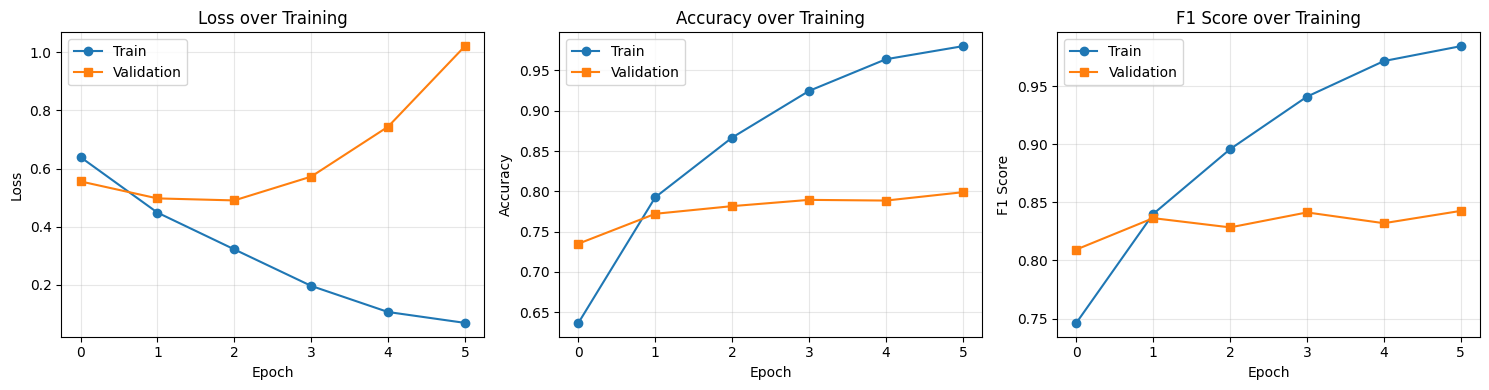

Training curves saved to: training_history.png


In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(history['train_loss'], label='Train', marker='o')
axes[0].plot(history['val_loss'], label='Validation', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss over Training')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train', marker='o')
axes[1].plot(history['val_acc'], label='Validation', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy over Training')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 plot
axes[2].plot(history['train_f1'], label='Train', marker='o')
axes[2].plot(history['val_f1'], label='Validation', marker='s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score over Training')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved to: training_history.png")


## Load Best Model for Inference


In [14]:
# Load best checkpoint
checkpoint = torch.load("albert_sentiment_best.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"Validation F1: {checkpoint['val_f1']:.3f}")


Loaded best model from epoch 3
Validation Loss: 0.4902
Validation F1: 0.828


## Inference Function


In [15]:
@torch.no_grad()
def predict_sentiment(texts, tokenizer, model, max_len=128, threshold=0.5, device=None):
    """Predict sentiment for input texts
    
    Args:
        texts: Single string or list of strings
        tokenizer: Tokenizer instance
        model: Trained model
        max_len: Maximum sequence length
        threshold: Classification threshold (default 0.5)
        device: Device to run inference on
    
    Returns:
        labels: Binary labels (1=positive, 0=negative)
        probs: Prediction probabilities
    """
    device = device or next(model.parameters()).device
    model.eval()
    
    if isinstance(texts, str):
        texts = [texts]
    
    # Clean texts
    texts = [clean_text(t) for t in texts]
    
    enc = tokenizer(
        texts, 
        truncation=True, 
        padding="max_length", 
        max_length=max_len, 
        return_tensors="pt"
    )
    
    logits = model(enc["input_ids"].to(device), enc["attention_mask"].to(device))
    probs = torch.sigmoid(logits).cpu().numpy()
    labels = (probs >= threshold).astype(int)
    
    return labels, probs


## Test Predictions


In [23]:
# Test examples
test_texts = [
    "Stock prices are soaring! Great quarterly earnings reported.",
    "Company faces bankruptcy, stocks plummet.",
    "Market remains stable with moderate growth.",
    "$AAPL breaking new records today! 🚀",
    "Massive losses reported in Q3, investors worried."
    "god i hate tesla"
]

labels, probs = predict_sentiment(test_texts, tokenizer, model, device=device)

print("\nTest Predictions:\n" + "="*80)
for text, label, prob in zip(test_texts, labels, probs):
    sentiment = "POSITIVE" if label == 1 else "NEGATIVE"
    print(f"Text: {text}")
    if label == 1:
        print(f"Sentiment: {sentiment} (confidence: {prob:.3f})")
    else:
        print(f"Sentiment: {sentiment} (confidence: {1-prob:.3f})")
    print("\n")



Test Predictions:
Text: Stock prices are soaring! Great quarterly earnings reported.
Sentiment: POSITIVE (confidence: 0.985)


Text: Company faces bankruptcy, stocks plummet.
Sentiment: NEGATIVE (confidence: 0.977)


Text: Market remains stable with moderate growth.
Sentiment: POSITIVE (confidence: 0.978)


Text: $AAPL breaking new records today! 🚀
Sentiment: POSITIVE (confidence: 0.928)


Text: Massive losses reported in Q3, investors worried.god i hate tesla
Sentiment: NEGATIVE (confidence: 0.935)




## Final Model Summary


In [17]:
print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
print(f"Architecture: ALBERT-base-v2 + Binary Classification Head")
print(f"Total Parameters: {total_params:,}")
print(f"Training Samples: {len(train_texts):,}")
print(f"Validation Samples: {len(val_texts):,}")
print(f"\nHyperparameters:")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Dropout: {DROPOUT}")
print(f"  - Weight Decay: {WEIGHT_DECAY}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Max Sequence Length: {MAX_LEN}")
print(f"\nOptimizations:")
print(f"  ✓ Early stopping (patience={PATIENCE})")
print(f"  ✓ Learning rate scheduling (warmup={WARMUP_STEPS} steps)")
print(f"  ✓ Higher dropout for regularization")
print(f"  ✓ Gradient clipping")
print(f"  ✓ Weight decay (L2 regularization)")
print(f"  ✓ Stratified train/val split")
print(f"\nBest Performance:")
print(f"  - Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"  - Validation F1: {checkpoint['val_f1']:.3f}")
print(f"  - Epoch: {checkpoint['epoch']+1}")
print("="*80)



MODEL SUMMARY
Architecture: ALBERT-base-v2 + Binary Classification Head
Total Parameters: 11,684,353
Training Samples: 4,632
Validation Samples: 1,159

Hyperparameters:
  - Learning Rate: 2e-05
  - Dropout: 0.3
  - Weight Decay: 0.01
  - Batch Size: 32
  - Max Sequence Length: 128

Optimizations:
  ✓ Early stopping (patience=3)
  ✓ Learning rate scheduling (warmup=100 steps)
  ✓ Higher dropout for regularization
  ✓ Gradient clipping
  ✓ Weight decay (L2 regularization)
  ✓ Stratified train/val split

Best Performance:
  - Validation Loss: 0.4902
  - Validation F1: 0.828
  - Epoch: 3
